In [1]:
# add repo path to the system path
from pathlib import Path
import os, sys
repo_path= Path.cwd().resolve()
while '.gitignore' not in os.listdir(repo_path): # while not in the root of the repo
    repo_path = repo_path.parent #go up one level
sys.path.insert(0,str(repo_path)) if str(repo_path) not in sys.path else None

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import ColorMode
from detectron2.structures import pairwise_iou, boxes

import torch
import cv2 as cv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Pretrained DBT detector

In [3]:
config_file = str(repo_path / 'data/models/config_trained_R_101_30k.yaml')
model_file = str(repo_path / 'data/models/model_final_R_101_omidb_30k_dbt9k_f12_gray.pth')
min_score = 1e-2 # minimum score to keep prediction


# load trained network 
cfg = get_cfg()
cfg.merge_from_file(config_file)
#Use the final weights generated after successful training for inference  
cfg.MODEL.WEIGHTS = model_file
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = min_score #0.8  # set the testing threshold for this model
# define predictor
predictor = DefaultPredictor(cfg)

In [4]:
# if a bbox is completely inside another bbox, remove the smaller one
def small_box_removal(bboxes):
    # sort bboxes by area
    bboxes = sorted(bboxes, key=lambda x: (x[2]-x[0])*(x[3]-x[1]), reverse=True)
    # remove small bboxes
    for i in range(len(bboxes)-1):
        for j in range(i+1, len(bboxes)):
            if (bboxes[i][0]<=bboxes[j][0] and bboxes[i][1]<=bboxes[j][1] and bboxes[i][2]>=bboxes[j][2] and bboxes[i][3]>=bboxes[j][3]):
                bboxes[j] = [0, 0, 0, 0]
    return boxes.Boxes([bbox for bbox in bboxes if bbox!=[0, 0, 0, 0]])


def remove_similar_bboxes(bboxes, iou_threshold=0.5):

    # order bboxes per area, largest first, if they are not ordered
    bboxes_ex = np.asanyarray(sorted(bboxes, key=lambda x: (x[2]-x[0])*(x[3]-x[1]), reverse=True))
    bboxes_ex = boxes.Boxes(bboxes_ex)
    list_bbox_id = list(range(len(bboxes_ex)))
    # comoute iou
    iou = pairwise_iou(bboxes_ex, bboxes_ex)
    iou_upper = torch.triu(iou, diagonal=1)
    for i in range(iou_upper.shape[0]):
        for j in range(iou_upper.shape[1]):
            if iou_upper[i, j]>iou_threshold and i!=j:
                print(f'iou between {i} and {j} is {iou_upper[i, j]}')
                # remove the smaller bbox from the list, because they are ordered, that is the one with the smaller index
                list_bbox_id.remove(j) if j in list_bbox_id else None

    return bboxes_ex[list_bbox_id]


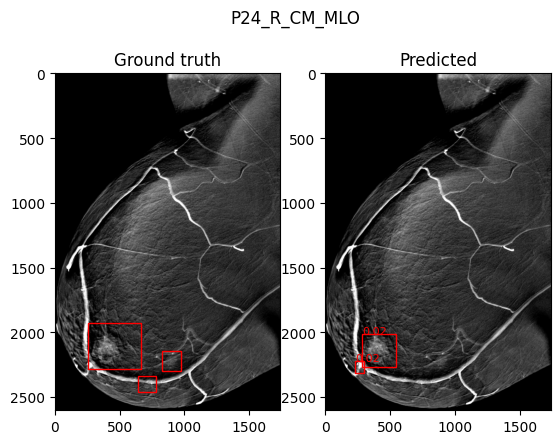

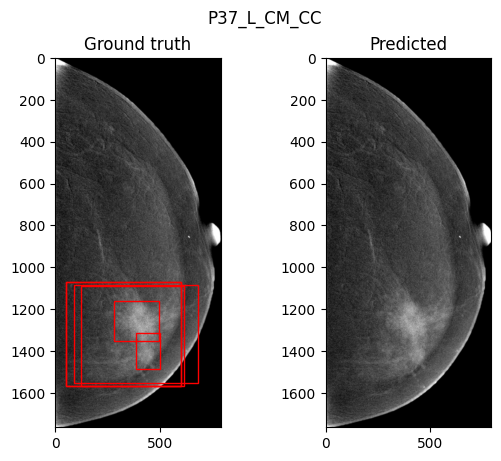

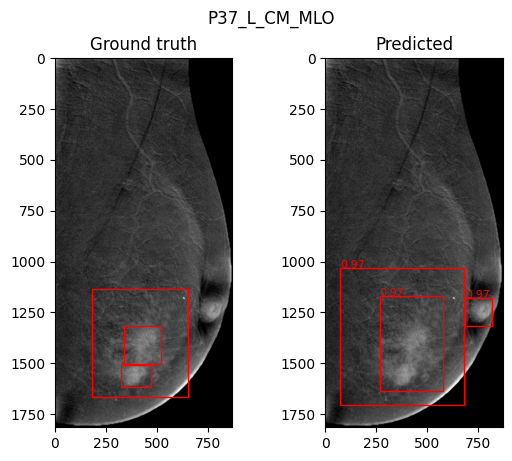

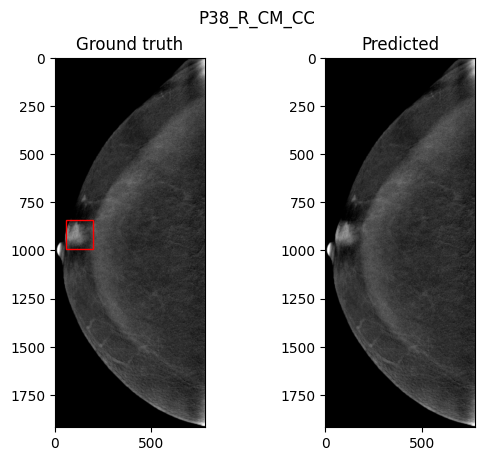

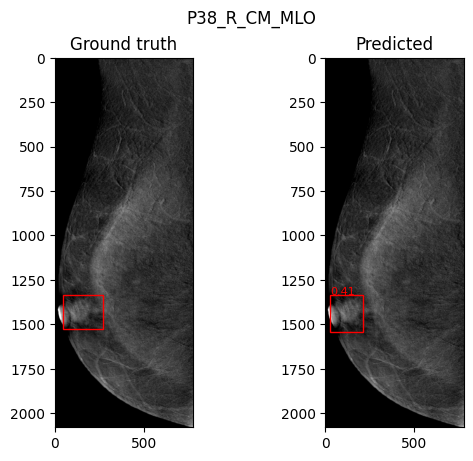

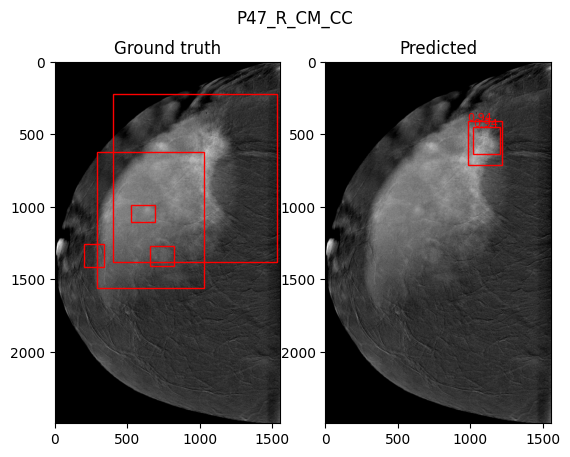

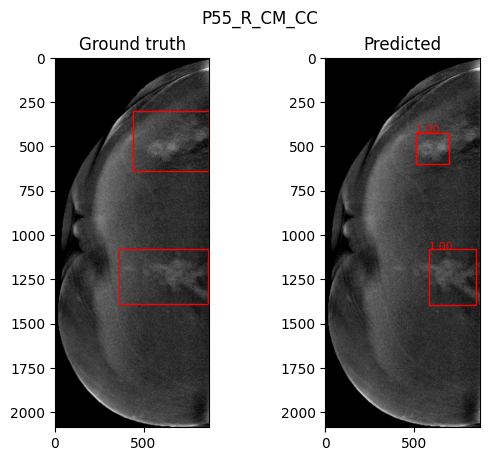

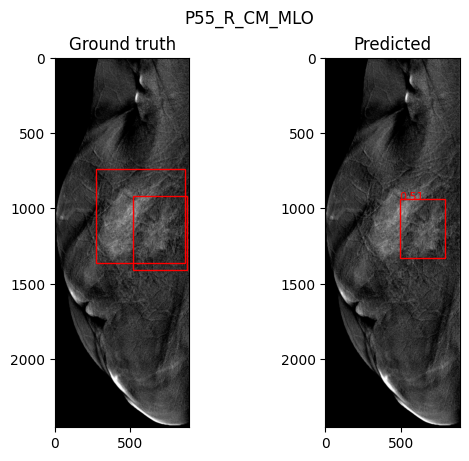

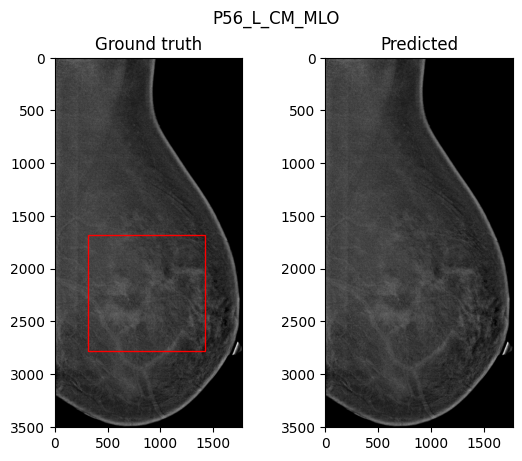

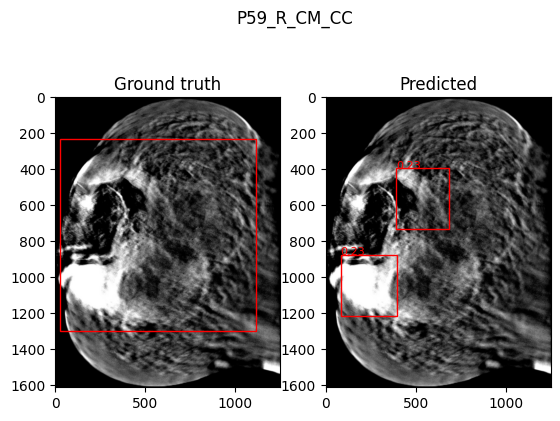

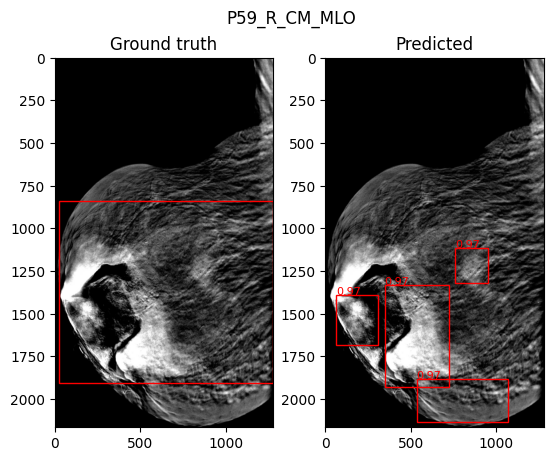

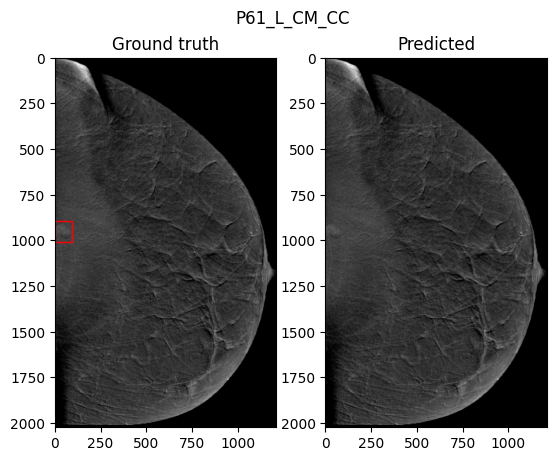

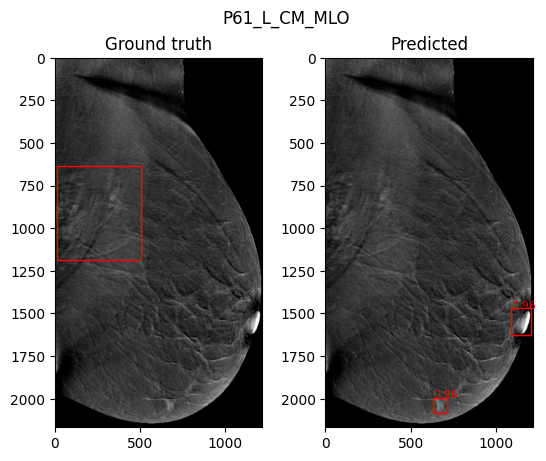

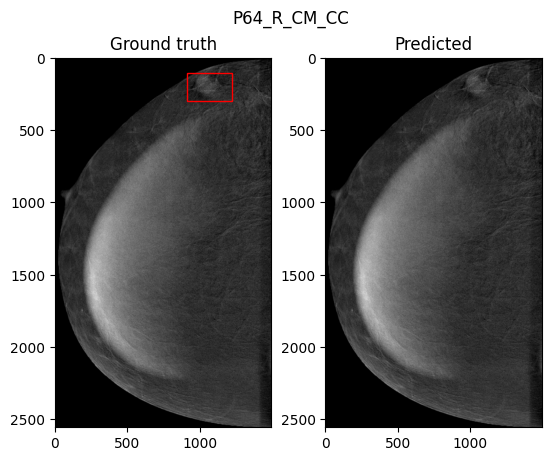

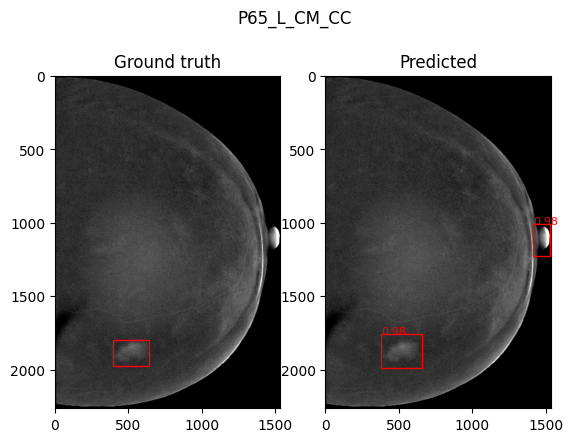

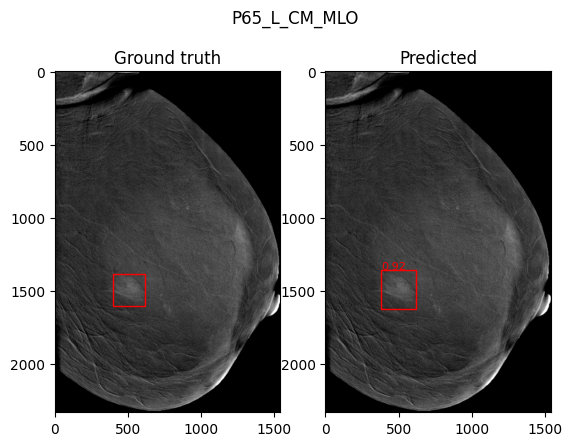

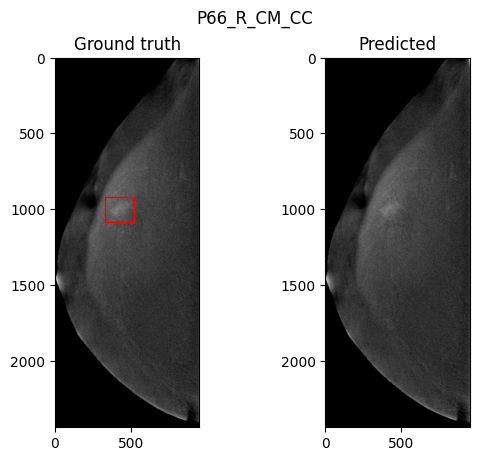

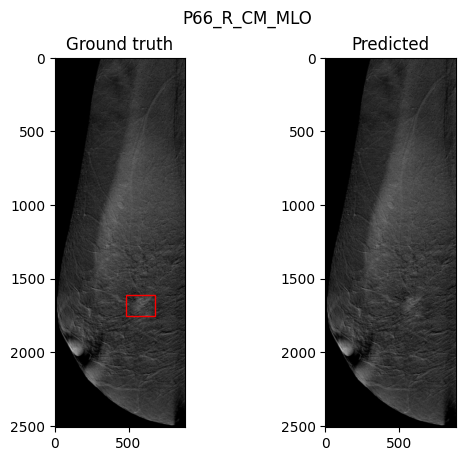

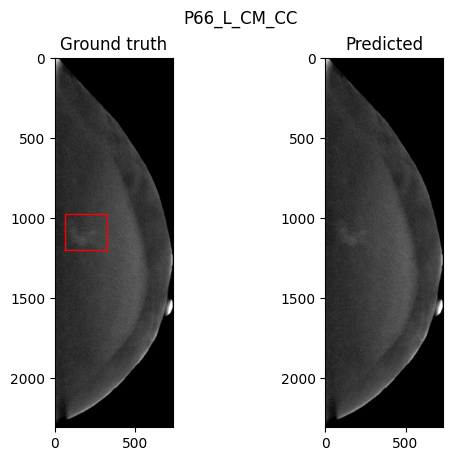

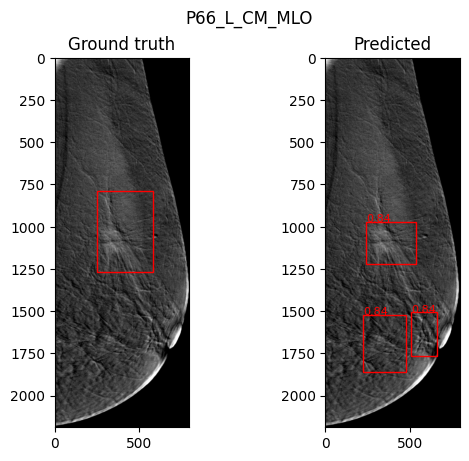

In [11]:
# settings
im_dir = repo_path / 'data/CDD-CESM/images/substracted'
bbox_dataframe = pd.read_csv(repo_path / 'data/CDD-CESM/masks/bbox_CESM.csv')

for im_name in bbox_dataframe['image_name'].unique()[10:30]:
    # print(f'Image: {im_name}')
    im_bboxes = bbox_dataframe[bbox_dataframe['image_name']==im_name]
    # get all regions bboxes
    bboxes_info = [eval(bbox) for bbox in im_bboxes['bbox']]
    # transform x, y, h, w to x1, y1, x2, y2
    gt_bboxes = [[bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]] for bbox in bboxes_info]
    # gt_bboxes = small_box_removal(gt_bboxes)
    # gt_bboxes = remove_similar_bboxes(gt_bboxes, iou_threshold=0.3)

    # read image
    im_path = im_dir / f'{im_name}.jpg'
    im_array = cv.imread(str(im_path))

    # predict bbox
    outputs = predictor(im_array)
    out = outputs["instances"].to("cpu")

    bboxes = out.pred_boxes
    scores = out.scores
    classes = out.pred_classes

    # show all bounding boxes on the image
    fig,ax = plt.subplots(1, 2)
    ax[0].imshow(im_array)
    ax[0].set_title('Ground truth')
    for bbox in gt_bboxes:
        rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2]-bbox[0],bbox[3]-bbox[1],linewidth=1,edgecolor='r',facecolor='none')
        ax[0].add_patch(rect)
    ax[1].imshow(im_array)
    ax[1].set_title('Predicted')
    for bbox in bboxes:
        rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2]-bbox[0],bbox[3]-bbox[1],linewidth=1,edgecolor='r',facecolor='none')
        ax[1].add_patch(rect)
        # add score
        ax[1].text(bbox[0],bbox[1],f'{scores[0]:.2f}',color='r',fontsize=8)
    # set figure tilte
    fig.suptitle(im_name)
    plt.show()